# Cars price prediction
Author: Andrii Zapukhlyi

## <span style="color:#05B6CB; text-decoration:underline">Data description</span>
### We have cars dataset with features including make, model, year, engine, and other properties.
### Our goal will be to predict the price of a car with Random Forest Regression

## <span style="color:#05B6CB; text-decoration:underline">Import packages and data</span>

In [1225]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import math


df = pd.DataFrame(pd.read_csv("data.csv"))
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


## <span style="color:#05B6CB; text-decoration:underline">Data overview</span>

In [1226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

At first, let's make the column names better

In [1227]:
df.rename(columns={'Engine Fuel Type': 'fuel_type', 
                   'Engine HP': 'hp', 
                   'Engine Cylinders': 'cylinders',
                   'Transmission Type': 'transmission',
                   'Driven_Wheels': 'drive_type',
                   'Number of Doors': 'doors',
                   'Market Category': 'category',
                   'Vehicle Size': 'size',
                   'Vehicle Style': 'style',
                   'highway MPG': 'highway_mpg',
                   'city mpg': 'city_mpg'}, inplace = True)
df.rename(columns = lambda x: x.lower(), inplace = True)

In [1228]:
len(df[df.duplicated()])

715

There are 715 duplicated rows in our dataset, so I will remove them

In [1229]:
df.drop_duplicates(inplace=True)

Now, we can see the dependencies between numeric values, but for this we need to get the names of the columns with numeric variable types

In [1230]:
categorical = [col for col in df.columns if df[col].dtypes == 'O']
num = [col for col in df.columns if df[col].dtypes != 'O']
categorical,num

(['make',
  'model',
  'fuel_type',
  'transmission',
  'drive_type',
  'category',
  'size',
  'style'],
 ['year',
  'hp',
  'cylinders',
  'doors',
  'highway_mpg',
  'city_mpg',
  'popularity',
  'msrp'])

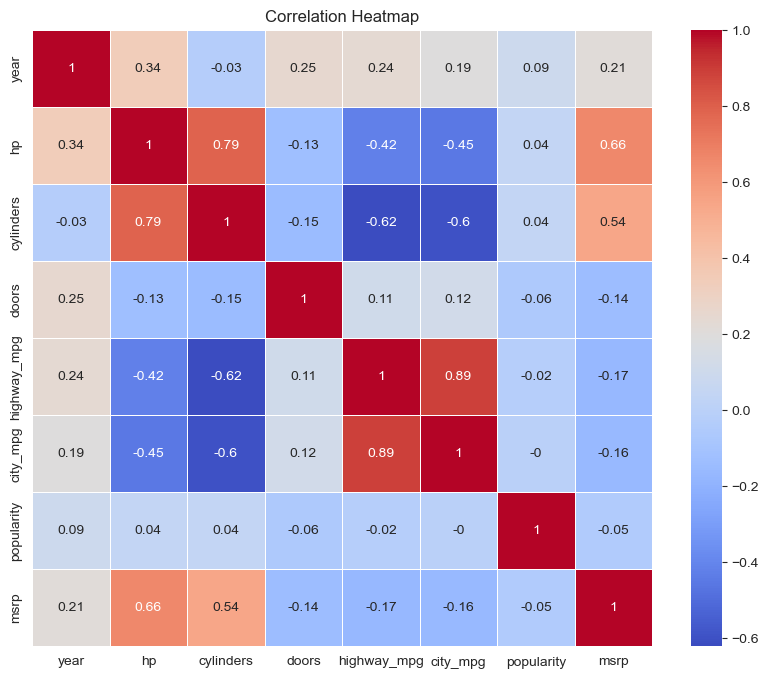

In [1231]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[num].corr().round(2), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

The graph above shows that the price strongly depends on the number of horsepower, cylinders and year of manufacture.
Also, the "popularity" column is weakly correlated with each column

Let's see if there are outliers in our data

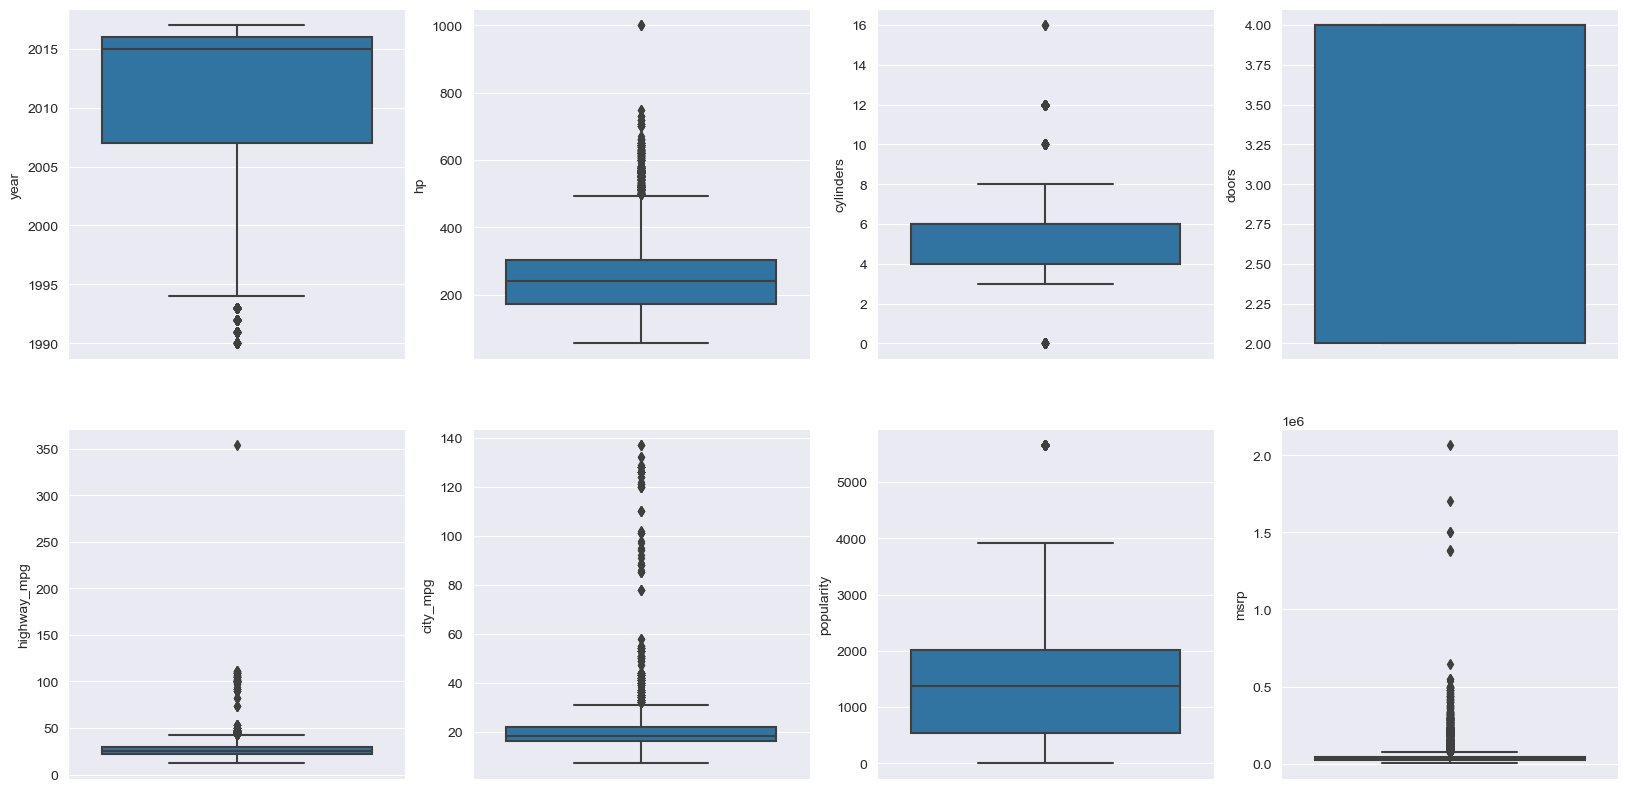

In [1232]:
def boxplots(dataset, p):
    fig, axis = plt.subplots(2, 4, figsize=[20, 10])
    idx=0
    axis=axis.flatten()
    for predictor in p:
        sns.boxplot(y=predictor, data=dataset[[predictor]], ax=axis[idx])
        idx+=1
    plt.show()
    
boxplots(df,num)

In [1233]:
df.describe()

,year,hp,cylinders,doors,highway_mpg,city_mpg,popularity,msrp
count,11199.000000,11130.000000,11169.000000,11193.000000,11199.000000,11199.000000,11199.000000,1.119900e+04
mean,2010.714528,253.388859,5.665950,3.454123,26.610590,19.731851,1558.483347,4.192593e+04
std,7.228211,110.150938,1.797021,0.872946,8.977641,9.177555,1445.668872,6.153505e+04
min,1990.000000,55.000000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03
25%,2007.000000,172.000000,4.000000,2.000000,22.000000,16.000000,549.000000,2.159950e+04
50%,2015.000000,239.000000,6.000000,4.000000,25.000000,18.000000,1385.000000,3.067500e+04
75%,2016.000000,303.000000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.303250e+04
max,2017.000000,1001.000000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06


We can see in the graphs that there are many outliers in hp, cylinders, highway_mpg, city_mpg and msrp columns.

## <span style="color:#05B6CB; text-decoration:underline">Data cleaning</span>

The missing values are in 3 numeric columns, and I will replace them with the median. 
However, I noticed that a few of the missing values in the 'cylinders' column are for electric cars, which is actually true because an electric motor has no cylinders. I will replace them with the value 0

In [1234]:
df[num].isnull().sum()

year            0
hp             69
cylinders      30
doors           6
highway_mpg     0
city_mpg        0
popularity      0
msrp            0
dtype: int64

In [1235]:
df[pd.isna(df.cylinders)]

,make,model,year,fuel_type,hp,cylinders,transmission,drive_type,doors,category,size,style,highway_mpg,city_mpg,popularity,msrp
1983,Chevrolet,Bolt EV,2017,electric,200.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,110,128,1385,40905
1984,Chevrolet,Bolt EV,2017,electric,200.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,110,128,1385,36620
3716,Volkswagen,e-Golf,2015,electric,115.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,105,126,873,33450
3717,Volkswagen,e-Golf,2015,electric,115.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,105,126,873,35445
3718,Volkswagen,e-Golf,2016,electric,115.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,105,126,873,28995
3719,Volkswagen,e-Golf,2016,electric,115.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,105,126,873,35595
5778,Mitsubishi,i-MiEV,2014,electric,NaN,NaN,DIRECT_DRIVE,rear wheel drive,4.0,Hatchback,Compact,4dr Hatchback,99,126,436,22995
5779,Mitsubishi,i-MiEV,2016,electric,66.0,NaN,DIRECT_DRIVE,rear wheel drive,4.0,Hatchback,Compact,4dr Hatchback,99,126,436,22995
5780,Mitsubishi,i-MiEV,2017,electric,66.0,NaN,DIRECT_DRIVE,rear wheel drive,4.0,Hatchback,Compact,4dr Hatchback,102,121,436,22995
8373,Toyota,RAV4 EV,2012,electric,154.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Crossover,Midsize,4dr SUV,74,78,2031,49800


In [1236]:
df.loc[df.fuel_type == 'electric', 'cylinders'].fillna(0, inplace=True)

In [1237]:
for col in num:
    median = df[col].median()
    df[col].fillna(median, inplace=True)

In [1238]:
df[categorical].isnull().sum()

make               0
model              0
fuel_type          3
transmission       0
drive_type         0
category        3376
size               0
style              0
dtype: int64

There are missing values in two columns with a categorical data type. I will delete the 'category' column because it has many missing values, but does not have a critical impact on the result. 
In the 'fuel_type' column, the missing values refer to the same car whose fuel type is 'regular unleaded'

In [1239]:
df[pd.isna(df.fuel_type)]

,make,model,year,fuel_type,hp,cylinders,transmission,drive_type,doors,category,size,style,highway_mpg,city_mpg,popularity,msrp
11321,Suzuki,Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Sedan,25,17,481,17199
11322,Suzuki,Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Sedan,25,17,481,20199
11323,Suzuki,Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Sedan,25,17,481,18499


In [1240]:
df.fuel_type.fillna('regular unleaded', inplace = True)
df.drop('category', axis = 1, inplace = True)
categorical.remove('category')

In [1241]:
df.isnull().sum()

make            0
model           0
year            0
fuel_type       0
hp              0
cylinders       0
transmission    0
drive_type      0
doors           0
size            0
style           0
highway_mpg     0
city_mpg        0
popularity      0
msrp            0
dtype: int64

Now, our dataset hasn't missing values

The next step is to remove outliers, I will do it using the IQR method

In [1242]:
column_with_outliers = ['hp', 'cylinders', 'highway_mpg', 'city_mpg', 'msrp']

def remove_outliers(dataset,col):
    iqr = dataset[col].quantile(0.75) - dataset[col].quantile(0.25)
    low_lim = dataset[col].quantile(0.25) - (iqr * 1.5)
    up_lim = dataset[col].quantile(0.75) + (iqr * 1.5)
    outliers = ((df[col] < low_lim) | (df[col] > up_lim))
    df.drop(df[outliers].index, inplace=True)

for col in df[column_with_outliers].columns:
    remove_outliers(df,col)

In [1243]:
df.describe()

,year,hp,cylinders,doors,highway_mpg,city_mpg,popularity,msrp
count,9811.000000,9811.000000,9811.000000,9811.000000,9811.000000,9811.000000,9811.000000,9811.000000
mean,2010.287636,231.507186,5.424727,3.504026,26.292223,19.170319,1556.742840,29146.519621
std,7.474648,77.770760,1.393489,0.842463,5.743508,4.375080,1463.129793,15586.143911
min,1990.000000,63.000000,3.000000,2.000000,12.000000,10.000000,21.000000,2000.000000
25%,2006.000000,170.000000,4.000000,3.000000,22.000000,16.000000,549.000000,20475.000000
50%,2014.000000,220.000000,6.000000,4.000000,26.000000,18.000000,1385.000000,29065.000000
75%,2016.000000,287.000000,6.000000,4.000000,30.000000,22.000000,2009.000000,38750.000000
max,2017.000000,485.000000,8.000000,4.000000,42.000000,31.000000,5657.000000,70750.000000


## <span style="color:#05B6CB; text-decoration:underline">Preprocessing</span>

In [1246]:
df = pd.get_dummies(df, columns = categorical)

In [1247]:
target = df.msrp
predictors = df.drop('msrp', axis = 1)

First, I encoded categorical variables into numeric variables
Now, I will split the dataset into training and test sets with the test size of 0.2

In [1248]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=1)

X_train.shape, X_test.shape

((7848, 824), (1963, 824))

In [1249]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Finally, I standardized my data by using StandardScaler

Our dataset is ready to modeling 

## <span style="color:#05B6CB; text-decoration:underline">Modeling</span>

I will use RandomForestRegressor to make prediction

In [1250]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

Below, you can see a scatter plot of the dependence of actual values relative to predicted values

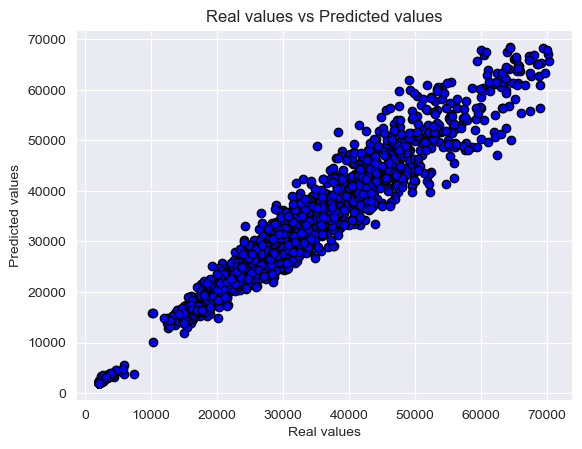

In [1251]:
plt.scatter(y_test, y_pred, c='blue', edgecolors='k')
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Real values vs Predicted values")
plt.show()

In [1252]:
r2 = round(r2_score(y_test, y_pred),2) 
rmse = round(math.sqrt(mean_squared_error(y_test, y_pred)),2)
mae = round(mean_absolute_error(y_test, y_pred),2)

print("R2 score:", r2, "\nRMSE:", rmse, "\nMAE:", mae)

R2 score: 0.96 
RMSE: 3278.45 
MAE: 2294.02


## <span style="color:#05B6CB; text-decoration:underline">Conclusion</span>
The model performed with good scores

